<a href="https://colab.research.google.com/github/rayaneghilene/Pytorch_Barcode_detection/blob/main/Barcode_detection_pytorch_lightning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytorch-lightning
!pip install torch-summary

# Barcode detection using CNN

In [ ]:
#Imports :

import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.datasets import MNIST, CIFAR10
from torchvision import transforms
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
import skimage
from skimage import io
from google.colab.patches import cv2_imshow
import cv2
import torchvision.transforms as transform
import pandas as pd
from sklearn.model_selection import train_test_split
from pytorch_lightning import loggers as pl_loggers
import pytorch_lightning as pl
import torchmetrics


# 1- Exploring the data

## Dataset
The dataset used for this project is provided by the "Applied Recognition Technology Laboratory Department of Theoretical and Applied Science"

*Neural Image Restoration For Decoding 1-D Barcodes Using Common Camera Phones
Alessandro Zamberletti, Ignazio Gallo, Moreno Carullo and Elisabetta Binaghi
Computer Vision, Imaging and Computer Graphics. Theory and Applications, Springer Berlin Heidelberg, 2011*

The following dataset will be divided into three sets:

- Training set is used to train the Model (i.e., to find the parameters of Model).
- Validation set is used to watch the Model's training (to verify whether the training procedure goes well).
- Test set is used to evaluate the performance of the Model (in our case, to measure if the model compresses and decompresses well new images).

##Creation of the Dataset

### Generating random barcodes

In [ ]:
!pip install python-barcode opencv-python


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 kB 5.2 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import barcode
from barcode import generate
from barcode.writer import ImageWriter

# Define your dataset directory
dataset_dir = '/content/generated_barcodes'

# Create the output directory for generated barcodes and annotations
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)

# Number of random barcodes to generate
num_barcodes = 1000

# Define barcode symbology (EAN-13, UPC-A, etc.)
barcode_symbology = 'ean13'

# Generate random barcodes and annotations
for i in range(num_barcodes):
    barcode_number = np.random.randint(100000000000, 999999999999)  # Generate a random 12-digit barcode number
    barcode_filename = f'barcode_{i}.png'
    barcode_filepath = os.path.join(dataset_dir, barcode_filename)

    # Generate barcode image
    with open(barcode_filepath, 'wb') as barcode_file:
        generate(barcode_symbology, str(barcode_number), writer=ImageWriter(), output=barcode_file)

    # Save annotation to annotation file
    annotation_filename = f'annotations.txt'
    annotation_filepath = os.path.join(dataset_dir, annotation_filename)
    with open(annotation_filepath, 'a') as annotation_file:
        annotation_file.write(f'{barcode_filename}: {barcode_number}\n')

    # Display the generated barcode


print("Random barcode generation and annotation completed.")


Random barcode generation and annotation completed.


##Creating the dataset

In [ ]:
!pip install imgaug


In [ ]:
import os
import cv2
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

# Define your dataset directory
dataset_dir = '/content/generated_barcodes'



# Custom dataset class
class BarcodeDataset(Dataset):
    def __init__(self, dataset_dir, transform=None):
        self.dataset_dir = dataset_dir
        self.data = []
        self.transform = transform

        # # Step 1: Load Images (without cropping and preprocessing)
        # for image_filename in os.listdir(dataset_dir):
        #     if image_filename.endswith('.png'):
        #         barcode_number = os.path.splitext(image_filename)[0]
        #         image_path = os.path.join(dataset_dir, image_filename)

        #         # Load image in grayscale
        #         image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        #         # Add the sample to the dataset
        #         self.data.append({
        #             'image': image,
        #             'barcode_number': barcode_number
        #         })
class BarcodeDataset(Dataset):
    def __init__(self, dataset_dir, transform=None):
        self.dataset_dir = dataset_dir
        self.data = []
        self.label_map = {}  # Mapping from barcode number to unique integer label
        self.label_counter = 0  # Counter to assign unique labels
        self.transform = transform
        # Step 1: Load Images (without cropping and preprocessing)
        for image_filename in os.listdir(dataset_dir):
            if image_filename.endswith('.png'):
                barcode_number = os.path.splitext(image_filename)[0]
                if barcode_number not in self.label_map:
                    self.label_map[barcode_number] = self.label_counter
                    self.label_counter += 1

                image_path = os.path.join(dataset_dir, image_filename)

                # Load image in grayscale
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

                # Add the sample to the dataset
                self.data.append({
                    'image': image,
                    'label': self.label_map[barcode_number]  # Use the integer label
                })


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        image = sample['image']
        label = sample['label']  # Integer label

        # Apply the specified transforms if provided
        if self.transform:
            image = self.transform(image)

        # Convert the label to a Tensor
        label = torch.tensor(label, dtype=torch.int64)

        return image, label



# Define transformations to apply to the images
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),  # Resize the image to the desired size
    transforms.ToTensor(),  # Convert to tensor
])

# Create an instance of your custom dataset with transforms
barcode_dataset = BarcodeDataset(dataset_dir, transform=transform)

# Split the dataset into training and testing (validation) sets
train_size = int(0.8 * len(barcode_dataset))
test_size = len(barcode_dataset) - train_size
train_dataset, test_dataset = random_split(barcode_dataset, [train_size, test_size])

# Create DataLoaders for training and testing
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# You can now use train_dataloader and test_dataloader for training and testing, respectively


###Spliting the data into three sets :Training, Testing and Validation

In [ ]:
# Split dataset into training and remaining data
train_data, test_data = train_test_split(barcode_dataset, test_size=0.2, random_state=42)

# # Split remaining data into testing and validation sets
# test_data, val_data = train_test_split(remaining_data, test_size=0.5, random_state=42)

# Print the sizes of each set
print("Train set size:", len(train_data))
print("Test set size:", len(test_data))


Train set size: 800
Test set size: 200


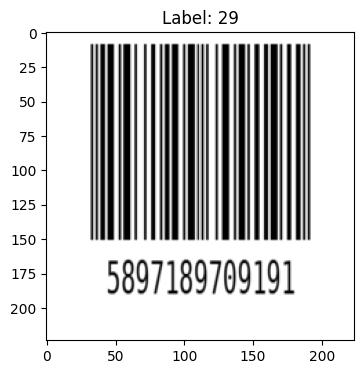

torch.Size([1, 224, 224])


In [ ]:
# TODO : Retrieve one sample of the Dataset.
sample = train_data[0]

# TODO : What is in a sample ? Print the sample to understand
# print(sample)

image, label =sample


plt.figure(figsize=(10, 4))
plt.imshow(image.permute(1,2,0), cmap='gray')  # Adjust the colormap as needed
plt.title(f"Label: {label}")
plt.show()
print(image.shape)


# Pytorch Lightning

## Lightning Data Module

In [ ]:
from pickle import TRUE
from torchvision.datasets.fakedata import FakeData
class BarcodeDataModule(pl.LightningDataModule):

    def __init__(self):
        super().__init__()
        self.transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
        self.data_dir = ''
        self.batch_size_train, self.batch_size_valid, self.batch_size_test = 32,32,32

    def prepare_data(self):
        # TODO : load the train and test dataset
        train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


    def setup(self, stage):
        #We need to setup our module. We have a training set that we will be fitting in our model
        #and a testing set used to test our models prediction.
        #the stage variable corresponds to those two steps :
        #         |fit
        # stage = <test
        #         |None

        #First stage is 'fit' (or None)
        if stage == "fit" or stage is None:
            # We create a validation split to watch the training.
            # TODO : Which dataset do we load for training ?
            barcode_dataset = BarcodeDataset(dataset_dir)
            train_size = int(0.8 * len(barcode_dataset))
            test_size = len(barcode_dataset) - train_size
            train_dataset, valid_dataset = random_split(barcode_dataset, [train_size, test_size])
            # Assign the datasets as attributes of the module
            self.train_data = train_data
            self.valid_dataset = valid_dataset


            #self.mnist_train = FashionMNIST(self.data_dir, train =False, transform=self.transform)

        #Second stage is 'test'
        if stage == "test" or stage is None:

            self.test_data = DataLoader(test_data, batch_size=batch_size, shuffle=True)
            # Question : What additional set can we create ? Why ?


    def train_dataloader(self):
        train_loader =  DataLoader(self.train_data, batch_size=batch_size, shuffle=True)
        return train_loader

    def val_dataloader(self):
        # TODO : Now create your Validation DataLoader
        val_loader =  DataLoader(self.valid_dataset, batch_size=batch_size, shuffle=True)
        return val_loader

    def test_dataloader(self):
        # TODO : Now create your Testing DataLoader
        test_loader =  DataLoader(self.test_data, batch_size=batch_size, shuffle=True)
        return test_loader


In [ ]:
import pytorch_lightning as pl
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets.fakedata import FakeData  # This import doesn't seem to be used

class BarcodeDataModule(pl.LightningDataModule):

    def __init__(self, dataset_dir, batch_size=32):
        super().__init__()
        self.transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
        self.dataset_dir = dataset_dir
        self.batch_size = batch_size

    def prepare_data(self):
        # TODO : load the train and test dataset
        train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    def setup(self, stage):
        # Load and split your dataset during setup
        if stage == "fit" or stage is None:
            # Create a custom BarcodeDataset if not already defined
            barcode_dataset = BarcodeDataset(self.dataset_dir, transform=self.transform)
            dataset_size = len(barcode_dataset)
            train_size = int(0.8 * dataset_size)
            val_size = dataset_size - train_size

            # Split the dataset into training and validation sets
            self.train_dataset, self.valid_dataset = random_split(barcode_dataset, [train_size, val_size])

    def train_dataloader(self):
        # Return the DataLoader for the training set
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        # Return the DataLoader for the validation set
        return DataLoader(self.valid_dataset, batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        # Create and return a DataLoader for your testing set
        # Assuming you have a test dataset in BarcodeDataset format
        test_dataset = BarcodeDataset(self.dataset_dir, transform=self.transform, train=False)
        return DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)


## Lightning Module

In [ ]:
import torch.optim as optim
import torch.nn as nn
import pytorch_lightning as pl

class BarcodeClassifier(pl.LightningModule):
    def __init__(self, output_shape, input_channels=1):
        super(BarcodeClassifier, self).__init__()
        self.output_shape = output_shape
        self.save_hyperparameters()

        # Define your model architecture
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3),  # Input channels should be 1
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3),

            nn.Flatten(),
            nn.Linear(509312, 128),  # Adjust the input size based on your image dimensions
            nn.ReLU(),
            nn.Linear(128, output_shape)
        )


    def forward(self, x):
        x = self.model(x)
        return x

    def configure_optimizers(self):
        optimizer = optim.SGD(self.parameters(), lr=0.001, momentum=0.9)
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        x1 = self(x)
        y = y.long()
        loss = nn.functional.cross_entropy(x1, y)

        predictions = torch.argmax(x1, dim=1)
        correct = (predictions == y).sum().item()
        acc = correct / len(y)

        self.log('train_loss', loss)
        self.log('train_acc', acc)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        x1 = self(x)

        loss = nn.functional.cross_entropy(x1, y)

        predictions = torch.argmax(x1, dim=1)
        correct = (predictions == y).sum().item()
        acc = correct / len(y)

        self.log('val_loss', loss)
        self.log('val_acc', acc)

    def test_step(self, batch, batch_idx):
        x, y = batch
        x1 = self(x)

        loss = nn.functional.cross_entropy(x1, y)

        predictions = torch.argmax(x1, dim=1)
        correct = (predictions == y).sum().item()
        acc = correct / len(y)
        self.acc = acc

        self.log('test_loss', loss)
        self.log('test_acc', acc)


# def training_step(self, batch, batch_idx):
#     x, y = batch
#     x1 = self(x)

#     loss = nn.functional.cross_entropy(x1, y)

#     predictions = torch.argmax(x1, dim=1)
#     correct = (predictions == y).sum().item()
#     acc = correct / len(y)

#     self.log('train_loss', loss)
#     self.log('train_acc', acc)
#     return {"loss": loss, "acc": acc}

    def test_epoch_start(self):
        self.acc = 0

    def on_test_epoch_end(self):
        self.log('Final Accuracy', self.acc)


## Lightning Training

In [ ]:
# TODO : Train
tb_logger = pl_loggers.TensorBoardLogger("Barcode detection model")

dm1 = BarcodeDataModule(dataset_dir='/content/generated_barcodes')
model1 = BarcodeClassifier(10)
# accel = 'cuda' if torch.cuda.is_available() else 'cpu'
trainer = pl.Trainer(max_epochs=10,accelerator='cpu',logger=tb_logger)
trainer.fit(model1, dm1)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 65.2 M
-------------------------------------
65.2 M    Trainable params
0         Non-trainable params
65.2 M    Total params
260.775   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

IndexError: ignored